In [2]:
# Metrics

# load new dataset
import pandas as pd
import numpy as np
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
print(df.head())

# classify label and feature
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

# encode the string label to numerical label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(pd.DataFrame(y).head())

# split dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_train_s = X_train[:, [4, 14]]  # a less compatable feature dataset for prediction 
X_test_s = X_test[:, [4, 14]]

         0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9   ...     22     23      24      25      26      27      28      29  \
0  0.14710  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.07017  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.12790  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.10520  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.10430  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       30       31  
0  0.4601  0.11890  
1  0.2750  0.08902  
2  0.

In [3]:
# build up pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

pipe_svc = make_pipeline(StandardScaler(), 
                         SVC(random_state=1, probability=True))

[[65  7]
 [29 13]]


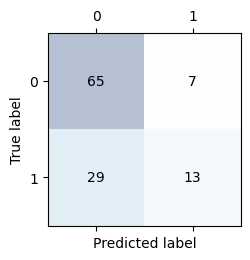

In [4]:
# confusion matrix
# ----------------

from sklearn.metrics import confusion_matrix

# get confusion matrix with test and predict data
pipe_svc.fit(X_train_s, y_train)
y_pred = pipe_svc.predict(X_test_s)
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confusion_mat)

# visualize confusion matrix
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i, 
                s=confusion_mat[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Precision score: 0.650
Recall score: 0.310
F1 score: 0.419


Text(0, 0.5, 'P: precision')

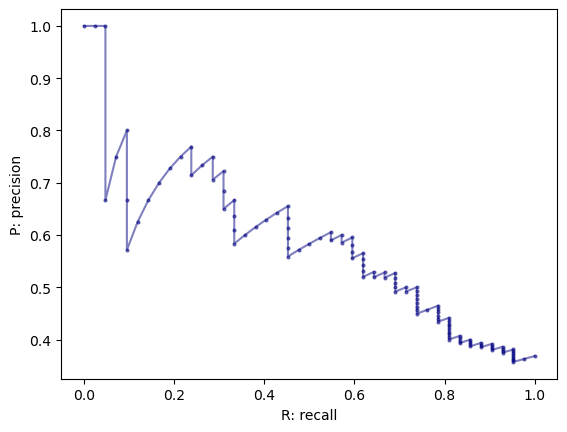

In [5]:
# precision and recall
# PRE = TP / (TP + FP)
# REC = TP / (FN + TP)
# F1 = 2 * (PRE * REC) / (PRE + REC)
# --------------------

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
import numpy as np

print('Precision score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1 score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

# visualize P-R curve
pipe_svc.fit(X_train_s, y_train)
y_proba = pipe_svc.predict_proba(X_test_s)
P, R, PRthreshold = precision_recall_curve(y_true=y_test, probas_pred=y_proba[:, 1], pos_label=1)
plt.plot(R, P, 
         marker='o', markersize=2, 
         color='navy', alpha=0.5)
plt.xlabel('R: recall')
plt.ylabel('P: precision')

In [6]:
# make scoreer to apply to GridSearch or RandomSearch
from sklearn.metrics import make_scorer, f1_score

c_gamma_range = [0.01, 0.1, 1.0, 10.0]
parameter_grid = [{'svc__C':c_gamma_range, 'svc__kernel':['linear']}, 
                  {'svc__C':c_gamma_range, 'svc__gamma':c_gamma_range, 'svc__kernel':['rbf']}]
scorer = make_scorer(score_func=f1_score, pos_label=0)

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=parameter_grid, 
                  scoring=scorer,           # we use customized scorer object for scoring
                  cv=10)
gs = gs.fit(X_train, y_train)
print('Best score: ', gs.best_score_)
print('Best parameters', gs.best_params_)

Best score:  0.9861994953378878
Best parameters {'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


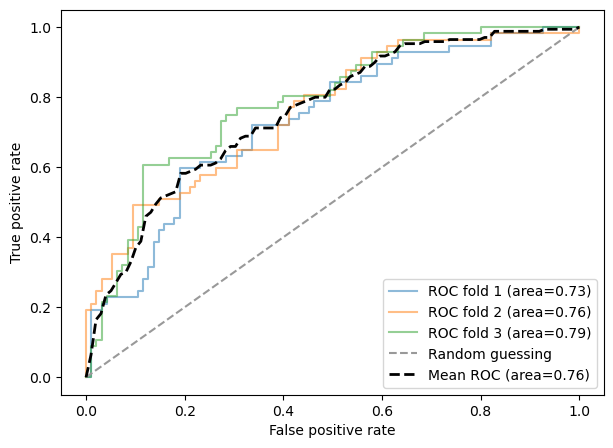

In [22]:
# ROC and AUC
# TPR = TP / (TP + FN) = REC
# FPR = FP / (FP + TN)
# --------------------

from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from numpy import interp
from scipy.interpolate import interp1d

pipe_lr = make_pipeline(StandardScaler(), 
                        PCA(n_components=2), 
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           solver='lbfgs', 
                                           C=100.0))
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, valid) in enumerate(cv):
    proba = pipe_lr.fit(X_train_s[train], y_train[train]).predict_proba(X_train_s[valid])
    fpr, tpr, threshold = roc_curve(y_true=y_train[valid], 
                                    y_score=proba[:, 1], 
                                    pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)  # interplote fpr and tpr with mean_fpr evaluation so that fpr(53) and tpr(53) will have 100 samples
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, alpha=0.5,
             label='ROC fold %d (area=%0.2f)' % (i+1, roc_auc))
    
# cross angle = random guessing line
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='Random guessing')

# draw mean tpr
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 
         'k--', label='Mean ROC (area=%0.2f)' % mean_auc, lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()